In [ ]:
#| default_exp state_estimators

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# State Estimators

These classes follow the same structure as ECMs, but use Bayesian Filtering to perform state estimation, assuming percept inputs are comming from an HMM, POMDP, or any kind of environment where the percept and environment state are not bijective. These state estimators assume that each dimension of a percept/sensory state takes one of a specified number of discrete values. The sample function returns a probability distribution over these values for each percept dimension/sensory category

### Bayesian Filter

Here we define the core bayesian filtering mechanisms for an state estimator with a pre-defined HMM representing the environment.

In [ ]:
#| export
import numpy as np
from projective_simulation.ECMs import Abstract_ECM

class Bayesian_Filter(Abstract_ECM):
    """
    Bayesian Filter for recursive state estimation.

    Each state/hypothesis posits:
      1. A probability for all states of K sensory categories (with discrete state spaces).
      2. A probability that each state/hypothesis will be true when the sensory category states are next updated.

    The filter maintains a belief state over these hypotheses/states, assuming they are exhaustive and mutually exclusive.

    Args:
        category_sizes (list): Number of states per sensory category.
        sensory_predictions (np.ndarray): Each row is a hypothesis; columns grouped by category_sizes, each group sums to 1.
        transition_predictions (np.ndarray): Each row is a hypothesis; columns give predicted probabilities for each hypothesis being true at the next step.
        belief_prior (np.ndarray, optional): Initial belief prior. If None, set to uniform.
        log_base (float, optional): Base for logarithms and exponentials.
        data_record (list, optional): List of internal variable names to record each time step. Accepts "all".
        record_until (int, optional): Number of time steps to record. Default -1 disables recording.
    """
    def __init__(
        self,
        category_sizes: list,
        sensory_predictions: np.ndarray,
        transition_predictions: np.ndarray,
        belief_prior: np.ndarray = None,
        log_base=2.,
        data_record: list = [],
        record_until: int = -1
    ):
        self.category_sizes = category_sizes
        self.category_indexer = np.repeat(np.arange(0, len(category_sizes)), category_sizes)
        self.num_hypotheses = np.shape(sensory_predictions)[0]
        self.transition_predictions = transition_predictions
        self.sensory_predictions = sensory_predictions
        self.log_base = log_base

        # --- State initialization ---
        self.percept = np.empty(len(self.category_sizes), dtype=int)
        self.likelihoods = np.zeros(self.num_hypotheses)
        self.belief_prior = np.full(self.num_hypotheses, 1/self.num_hypotheses) if belief_prior is None else belief_prior
        self.sensory_expectation = self.belief_prior @ self.sensory_predictions
        self.belief_posterior = np.full(self.num_hypotheses, 1/self.num_hypotheses)
        self.prepare_data_storage(data_record, record_until)

    def _check_structure(self):
        if sum(self.category_sizes) != np.shape(self.sensory_predictions)[1]:
            raise ValueError("sensory_predictions must have a number of columns equal to the total number of percept category states")

        if np.shape(self.sensory_predictions)[0] != np.shape(self.transition_predictions)[0]:
            raise ValueError("sensory_predictions and transition_predictions must have the same number of rows")
        if np.shape(self.transition_predictions)[0] != np.shape(self.transition_predictions)[1]:
            raise ValueError("transition_predictions must be square")
        
        #~~Enforcement of probability distributions~~
        for k in range(len(self.category_sizes)):
            pred_sum = np.sum(self.sensory_expectation[self.category_indexer == k])
            if not np.abs(pred_sum - 1) < 1e-9:
                raise ValueError(
                    f"Predictions for each sensory category must be a probability distribution. "
                    f"Timer={self.timer}, category={i}"
                )
            for i in range(self.num_hypotheses):
                if not np.abs(np.sum(self.sensory_predictions[i, self.category_indexer == k]) - 1) < 1e-9:
                    raise ValueError("Each sensory category must sum to 1 in every hypothesis")
        if not np.abs(np.sum(self.belief_posterior) - 1) < 1e-9:
            raise ValueError("belief_posterior must sum to 1")
        if not np.abs(np.sum(self.belief_prior) - 1) < 1e-9:
            raise ValueError("belief_prior must sum to 1")
        if not (np.all(self.likelihoods >= 0) and np.all(self.likelihoods <= 1)):
            raise ValueError("likelihoods must be between 0 and 1")
        #~~End enforcement of probability distributions~~

        if self.record_until is not None:
            if self.record_until >= 0 and self.data_timer == self.record_until + 1:
                print("Warning: memory process exceeded steps pre-allocated for data-recording.")

    def prepare_data_storage(self, data_record, record_until):
        """Set up data recording structure for diagnostics and visualization."""
        self.data_dic = {
            "belief_prior": None,
            "likelihoods": None,
            "belief_posterior": None,
            "sensory_expectation": None,
            "surprise": None
        }
        self.data_timer = 0
        self.record_until = record_until

        if "all" in data_record:
            if len(data_record) > 1:
                print("Warning: 'all' in data_record; additional entries ignored")
            data_record = self.data_dic.keys()

        if self.record_until < 0 and len(data_record) > 0:
            print("Warning: data_record set but record_until < 0; no data will be recorded")

        for variable in data_record:
            if variable not in self.data_dic:
                print(f"Warning: {variable} not a valid variable name; ignored")
            elif variable in ["belief_prior", "likelihoods", "belief_posterior"]:
                self.data_dic[variable] = np.full((self.record_until, self.num_hypotheses), -1., dtype=float)
            elif variable == "sensory_expectation":
                self.data_dic[variable] = np.full((self.record_until, np.sum(self.category_sizes)), -1., dtype=float)
            elif variable == "surprise":
                self.data_dic[variable] = np.full((self.record_until, len(self.category_sizes)), -1., dtype=float)

    def sample(self, percept) -> np.ndarray:
        """
        Given a percept, update belief and return a vector of sensory expectations.
        """
        self._check_structure()
        assert isinstance(percept, np.ndarray)
        assert np.issubdtype(percept.dtype, np.integer)
        if self.data_timer < self.record_until and self.data_dic["belief_prior"] is not None:
            self.data_dic["belief_prior"][self.data_timer, :] = self.belief_prior
        if self.data_timer < self.record_until and self.data_dic["sensory_expectation"] is not None:
            self.data_dic["sensory_expectation"][self.data_timer, :] = self.sensory_expectation

        self.percept = percept
        self.update_likelihoods(percept)
        if self.data_timer < self.record_until and self.data_dic["likelihoods"] is not None:
            self.data_dic["likelihoods"][self.data_timer, :] = self.likelihoods

        if self.data_timer < self.record_until and self.data_dic["surprise"] is not None:
            self.data_dic["surprise"][self.data_timer, :] = self.get_surprise()

        self.update_belief_posterior()
        if self.data_timer < self.record_until and self.data_dic["belief_posterior"] is not None:
            self.data_dic["belief_posterior"][self.data_timer, :] = self.belief_posterior
        
        self.learn(percept) # Placeholder for learning step in child classes

        self.update_priors()

        self.data_timer += 1
        return self.sensory_expectation

    def update_likelihoods(self, percept: np.ndarray):
        """Update the likelihoods for each hypothesis/state given the new percept."""
        if percept.shape[0] != len(self.category_sizes):
            raise ValueError(f'Percept vector size of {percept.shape[0]} does not match the number of perceptual categories, {len(self.category_sizes)}.')
        for i in range(len(self.category_sizes)):
            if percept[i] not in range(self.category_sizes[i]):
                raise ValueError("Percept state out of range for category.")
        one_hot_percept = self.get_one_hot_percept() # boolean mask for current percept's one-hot encoding
        category_likelihoods = self.sensory_predictions[:, one_hot_percept] # shape (num_hypotheses, num_categories)
        self.likelihoods = np.prod(category_likelihoods, axis=1) # shape (num_hypotheses,)

    def update_belief_posterior(self):
        """Update the posterior belief over hypotheses."""
        unnormalized_posterior = self.likelihoods * self.belief_prior # element-wise product
        normalization_constant = np.sum(unnormalized_posterior)
        if np.sum(unnormalized_posterior) != 0:
            self.belief_posterior = unnormalized_posterior / normalization_constant
        else:
            print("Warning: unnormalized posterior probabilities sum to 0. Model may be invalid.")
            self.belief_posterior = np.zeros(self.num_hypotheses)
        
    def learn(self, percept = None):
        """
        Placeholder for learning step in child classes.
        """
        pass

    def update_priors(self):
        """Update the prior belief and sensory expectation for the next step."""
        self.update_belief_prior()
        self.sensory_expectation = self.belief_prior @ self.sensory_predictions # sum of sensory state probabilities weighted across states/hypotheses by prior belief

    def update_belief_prior(self):
        """Update the prior belief using the transition predictions and posterior."""
        row_sums = self.transition_predictions.sum(axis=1, keepdims=True)
        assert np.all(np.abs(row_sums - 1) < 1e-9), "Each row of transition_predictions must sum to 1"
        self.belief_prior = self.belief_posterior @ self.transition_predictions

    def get_surprise(self) -> float:
        """Compute the total surprise of the network. 0 likelihood observations (inf surprise) return -1."""
        category_likelihoods = self.sensory_expectation[self.get_one_hot_percept()]
        mask = category_likelihoods == 0. # avoids log(0)
        surprise_values = np.full(category_likelihoods.shape, -1.)
        surprise_values[~mask] = -np.log(category_likelihoods[~mask]) / np.log(self.log_base)
        return surprise_values

    def get_one_hot_percept(self):
        """Return a boolean mask for the current percept's one-hot encoding."""
        one_hot_percept = np.zeros(np.sum(self.category_sizes), dtype=bool)
        one_hot_percept[np.cumsum(self.category_sizes) - self.category_sizes + self.percept] = True
        return one_hot_percept

### Bayesian Filter Example
Here we provide a simple example of a Bayesian Filter for an environment in a deterministic cycles. This environment produces the percept sequence "green" "off" "blue" "off", then repeats.

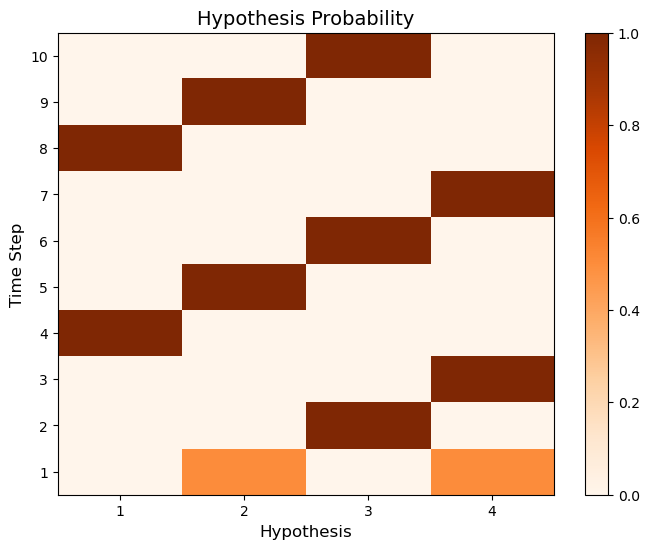

In [ ]:
from projective_simulation.environments import Cyclic_Env
from projective_simulation.methods.visualization import plot_heatmap

#define percepts
off = 0
green = 1
blue = 2
colormap = np.array(['lightgrey', 'green', 'blue']) #for plotting

#define environment
percept_cycle = np.array([green,off,blue,off]) #light off, light green, light off, light blue
simple_light_cycle = Cyclic_Env(percept_cycle, initial_state = 1) #start with light off to get aliasing


#define agent
category_sizes = [3]
sensory_predictions = simple_light_cycle.observation_function
transition_predictions = simple_light_cycle.transition_function[:,:,0] #Removes action dimension added by environment constructor
test_bayesian_filter = Bayesian_Filter(category_sizes = category_sizes,
                                       sensory_predictions = sensory_predictions,
                                       transition_predictions = transition_predictions
                                      )

#prepare simulation
T = 10 #total time to run simulation
test_bayesian_filter.prepare_data_storage(data_record = ["all"], record_until = T)

#simulate
for t in range(T): #state in light of state to create initial aliasing
    percept = simple_light_cycle.get_observation()
    test_bayesian_filter.sample(percept)
    simple_light_cycle.transition(0) #use action 0

#plot memory trace activations over time
plot_heatmap(test_bayesian_filter.data_dic["belief_posterior"], 
             title = "Hypothesis Probability", 
             color = "Oranges", xlabel = "Hypothesis")

### Sequence Memory
#### Constructor Methods

In [ ]:
#| export
import numpy as np
def Initialize_Memory_Based_Transition_Matrix(memory_capacity, 
                                              memory_bias, 
                                              num_hypotheses, 
                                              capacity_overflow_method, 
                                              schematic_transition_method="first"):
    """
    Initializes a transition matrix for a memory-based ECM with a given memory capacity and memory bias.
    If transition_predictions is provided, it will be used as the base transition matrix. Otherwise, a default matrix will be created.
    The schematic_transition_method determines how the transition matrix is structured:
        - "encoded": Memory hypotheses have a self-loop with probability 1 - memory_bias and transition to the timer hypothesis with probability memory_bias.
        - "loop": Memory hypotheses transition to the next memory hypothesis in a loop.
        - "stop": Memory hypotheses do not transition to any other hypothesis (self-loop with probability 1).
    """
    transition_predictions = np.zeros((num_hypotheses, num_hypotheses))
    # Fill the shifted diagonal for memory hypotheses (i.e., each i transitions to i+1, last to first)
    for i in range(memory_capacity):
        transition_predictions[i, (i + 1) % memory_capacity] = 1.0

    if capacity_overflow_method == "stop encoding" or schematic_transition_method == "learned":
        transition_predictions[memory_capacity - 1, 0] = memory_bias
        for i in range(memory_capacity, num_hypotheses):
            transition_predictions[i, i] = 1 - memory_bias
            transition_predictions[i, 0] = memory_bias
            transition_predictions[memory_capacity - 1, i] = (1-memory_bias) / (num_hypotheses - memory_capacity)
    elif capacity_overflow_method == "loop":
        for i in range(memory_capacity, num_hypotheses):
            transition_predictions[i, i] = 1 - memory_bias
            transition_predictions[i, 0] = memory_bias
    else:
        raise ValueError(f'{capacity_overflow_method} is not a valid capacity overflow method')

    return transition_predictions

def Initialize_Sensory_Predictions(category_sizes, num_hypotheses):
    """
    Initializes a sensory prediction matrix for a memory-based ECM with a given category sizes and number of hypotheses.
    """
    uniform_probabilities = np.concatenate([
        np.full(category_size, 1 / category_size) for category_size in category_sizes
            ])
    sensory_predictions = np.tile(uniform_probabilities, (num_hypotheses, 1))

    return sensory_predictions

In [ ]:
#| export
from projective_simulation.methods.transforms import _logistic, _exponentiated_shift
import numpy as np

class Sequence_Memory(Bayesian_Filter):
    """
    Memory-augmented Bayesian filter that encodes a sequence of percepts as memory traces.
    Each memory trace is a hypothesis about the environment, and the agent can transition between
    non-memory and memory hypotheses. Supports dynamic modification of internal weights to encode temporal traces.

    Args:
        category_sizes (list): Number of sensory input elements.
        memory_capacity (int): Number of memory-based hypotheses.
        memory_bias (float): Probability of transitioning from non-memory to memory hypothesis space.
        sensory_predictions (np.ndarray, optional): Sensory hypotheses matrix. If None, initialized to uniform.
        belief_prior (np.ndarray, optional): Initial belief priors. If None, all prior on non-memory hypothesis.
        transition_predictions (np.ndarray, optional): Hypothesis transition matrix.
        timer (int, optional): Starting memory time index.
        capacity_overflow_method (str, optional): 'loop' or 'stop encoding'.
        data_record (list, optional): List of variable names to log each time step. Accepts "all".
        record_until (int, optional): Number of steps to prepare for data logging. Negative disables recording.
    """
    def __init__(
        self,
        category_sizes: list,
        memory_capacity: int,
        memory_bias: float,
        sensory_predictions: np.ndarray = None,
        belief_prior: np.ndarray = None,
        transition_predictions: np.ndarray = None,
        timer: int = 0,
        capacity_overflow_method="stop encoding",
        data_record: list = [],
        record_until: int = -1
    ):
        """
        Initialize the Sequence_Memory filter.
        """
        self.memory_capacity = memory_capacity
        self.memory_bias = memory_bias
        self.capacity_overflow_method = capacity_overflow_method
        self.num_non_memory_hypotheses = 1
        self.timer = timer
        self.effective_capacity = min(self.timer, self.memory_capacity)

        num_hypotheses = self.num_non_memory_hypotheses + self.memory_capacity
        #default to uniform sensory predictions if not provided
        if sensory_predictions is None:
            sensory_predictions = Initialize_Sensory_Predictions(
                category_sizes=category_sizes,
                num_hypotheses=num_hypotheses
            )

        #default to transition matrix that encodes sequence memory if not provided
        if transition_predictions is None:
            transition_predictions = Initialize_Memory_Based_Transition_Matrix(
                memory_capacity=self.memory_capacity,
                memory_bias=self.memory_bias,
                num_hypotheses=num_hypotheses,
                capacity_overflow_method=self.capacity_overflow_method
            )
        
        super().__init__(
            sensory_predictions=sensory_predictions,
            transition_predictions=transition_predictions,
            category_sizes=category_sizes,
            belief_prior=belief_prior,
            data_record=data_record,
            record_until=record_until
        )

        if belief_prior is None:
            self.belief_prior = np.zeros(self.num_hypotheses)
            self.belief_prior[self.memory_capacity:] = 1 / self.num_non_memory_hypotheses
        
        #overide placeholder belief posterior initialization from parent class to meet new requirements
        self.belief_posterior = np.zeros(self.num_hypotheses)
        self.belief_posterior[self.memory_capacity:] = 1 / self.num_non_memory_hypotheses 

    def _check_structure(self):
        """
        Check that all internal probability distributions are valid (Per Parent class).
        Check that no belief is assigned to unencoded memory slots.
        """
        super()._check_structure()
        if self.effective_capacity < self.memory_capacity:
            if np.sum(self.belief_prior[self.effective_capacity:self.memory_capacity]) > 1e-9:
                raise ValueError("Posterior belief assigned to unencoded memory slot.")

    def sample(self, percept):
        """
        Given a percept; update belief state, update world model, predict next sensor states.

        Args:
            percept (np.ndarray): The observed percept.

        Returns:
            np.ndarray: The predicted sensory expectation for the next step.
        """
        super().sample(percept)
        self.timer = (self.timer + 1) % self.memory_capacity
        return self.sensory_expectation
    
    def learn(self, percept  = None):
        """
        Encode the current percept into memory by updating the sensory and transition predictions.
        """
        if percept is None:
            percept = self.percept
        if self.effective_capacity < self.memory_capacity or not self.capacity_overflow_method == "stop encoding":
            # if last memory slot filled and looping, update transition matrix to loop and decouple non-memory hypotheses
            if self.effective_capacity + 1 == self.memory_capacity:
                self.capacity_reached()
            self.encode_memory(percept)
        self._check_structure()

    def capacity_reached(self):
        """
        Handle encoding of last memory hypothesis when memory capacity is reached.
        """
        if self.capacity_overflow_method == "loop":
            self.transition_predictions[self.effective_capacity, :] = 0
            self.transition_predictions[self.effective_capacity, 0] = 1
            for i in range(self.memory_capacity, self.num_hypotheses):
                self.transition_predictions[i, i] = 1
                self.transition_predictions[i, 0] = 0   

    def encode_memory(self, percept):
        """
        Encode the current percept into memory by updating the sensory and transition predictions.
        """
        if self.effective_capacity < self.memory_capacity:
            self.effective_capacity += 1
            
        categorical_encoding = self.get_one_hot_percept().astype(float)
        self.sensory_predictions[self.timer, :] = categorical_encoding

            

#### Example Sequence memory

In this example, set up a cyclical Hidden Markov Process in which a light turns green, turns off, turns blue, turns off, then turns green again and restarts. We show how to pass the percepts from this environment to the Memory Network, record the network's internal states over time, and visualize these states after simuluation.

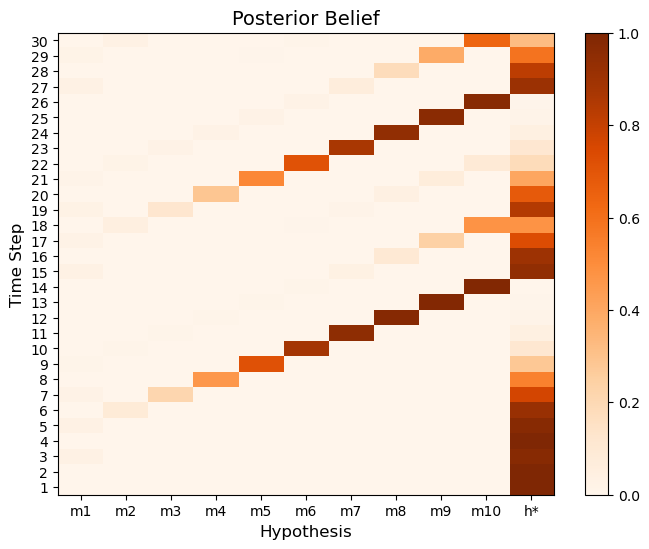

In [ ]:
from projective_simulation.environments import Cyclic_Env
from projective_simulation.methods.visualization import plot_heatmap

#define percepts
off = 0
green = 1
blue = 2
colormap = np.array(['lightgrey', 'green', 'blue']) #for plotting

#define environment
percept_cycle = np.array([green,off,blue,off]) #light off, light green, light off, light blue
simple_light_cycle = Cyclic_Env(percept_cycle, initial_state = 1) #start with light off to get aliasing


#define agent
category_sizes = [3]
memory_capacity = 10
memory_bias = 0.01
test_sequence_memory = Sequence_Memory(category_sizes = category_sizes,
                                              memory_capacity = memory_capacity,
                                              memory_bias = memory_bias
                                      )

#prepare simulation
T = 30 #total time to run simulation
test_sequence_memory.prepare_data_storage(data_record = ["all"], record_until = T)

#simulate
for t in range(T):
    percept = simple_light_cycle.get_observation()
    test_sequence_memory.sample(percept)
    simple_light_cycle.transition(0) #Use action 0 for no-action environments

#plot memory trace activations over time
plot_heatmap(test_sequence_memory.data_dic["belief_posterior"], 
             title = "Posterior Belief", 
             color = "Oranges", 
             xlabel="Hypothesis",
             xtick_labels=["m1","m2","m3","m4","m5","m6","m7","m8","m9","m10","h*"])

### Short-Term Memory Filter

In [ ]:
#| export
from projective_simulation.methods.transforms import _decay_toward_uniform

class Short_Term_Memory(Sequence_Memory):
    """
    Short-Term Memory filter that extends Sequence_Memory by introducing memory fading.
    Each encoded memory trace fades toward a uniform distribution at a specified rate.
    Supports different schematic transition methods and capacity overflow behaviors.

    Args:
        category_sizes (list): Number of sensory input elements.
        memory_capacity (int): Number of memory nodes.
        memory_bias (float): Transition probability from non-memory to memory hypothesis.
        fading_rate (float): Rate parameter for exponential decay toward uniform for memory traces.
        sensory_predictions (np.ndarray, optional): Optional sensory-to-memory weight matrix.
        belief_prior (np.ndarray, optional): Optional 1d array of prior expectations on memories.
        transition_predictions (np.ndarray, optional): Optional memory transition matrix.
        timer (int, optional): Starting memory time index.
        data_record (list, optional): List of variable names to record each time step. Accepts "all".
        record_until (int, optional): Number of steps to prepare for data recording. Negative disables recording.
        capacity_overflow_method (str, optional): 'loop' or 'stop encoding'.
        schematic_transition_method (str, optional): 'encoded', 'first', or 'learned'.
    """
    def __init__(
        self,
        category_sizes: list,
        memory_capacity: int,
        memory_bias: float,
        fading_rate: float,
        sensory_predictions: np.ndarray = None,
        belief_prior: np.ndarray = None,
        transition_predictions: np.ndarray = None,
        timer: int = 0,
        data_record: list = [],
        record_until: int = -1,
        capacity_overflow_method="loop",
        schematic_transition_method="encoded"
    ):
        """
        Initialize the Short_Term_Memory filter.
        """
        super().__init__(
            category_sizes=category_sizes,
            memory_capacity=memory_capacity,
            memory_bias=memory_bias,
            sensory_predictions=sensory_predictions,
            belief_prior=belief_prior,
            transition_predictions=transition_predictions,
            timer=timer,
            data_record=data_record,
            record_until=record_until,
            capacity_overflow_method=capacity_overflow_method
        )
        self.fading_rate = fading_rate
        self.schematic_transition_method = schematic_transition_method

        if self.schematic_transition_method == "encoded" and transition_predictions is None:
            for i in range(self.memory_capacity, np.shape(self.transition_predictions)[0]):
                self.transition_predictions[i, i] = 1 - self.memory_bias
                self.transition_predictions[i, self.timer] = self.memory_bias

    def learn(self, percept):
        """
        Fade all memory traces, then update memory with the new percept.

        Args:
            percept (np.ndarray): The observed percept.

        Returns:
            np.ndarray: The predicted sensory expectation for the next step.
        """
        self.fade()
        return super().learn(percept)

    def encode_memory(self, percept):
        """
        Encode the current percept into memory, updating sensory and transition predictions.
        Handles schematic transition methods and capacity overflow.
        """
        super().encode_memory(percept)
        if self.schematic_transition_method == "encoded":
            for i in range(self.memory_capacity, self.num_hypotheses):
                self.transition_predictions[i, :self.effective_capacity] = self.memory_bias/self.effective_capacity
        elif self.schematic_transition_method == "learned":
            for i in range(self.memory_capacity,self.num_hypotheses):
                #add weight to transition from non-memory hypotheses to current memory hypothesis then renormalize
                self.transition_predictions[i, self.timer] = self.memory_bias/self.effective_capacity
                self.transition_predictions[i,:] = self.transition_predictions[i,:] / np.sum(self.transition_predictions[i,:])


    def capacity_reached(self):
        """
        Handle encoding of last memory hypothesis when memory capacity is reached.
        Overwrites method from Sequence Memory to handle schematic transition methods.
        """
        if self.capacity_overflow_method == "loop":
            self.transition_predictions[self.effective_capacity, :] = 0
            self.transition_predictions[self.effective_capacity, 0] = 1
            if not self.schematic_transition_method == "encoded":
                for i in range(self.memory_capacity, self.num_hypotheses):
                    self.transition_predictions[i, i] = 1
                    self.transition_predictions[i, 0] = 0 

    def fade(self):
        """
        Apply exponential decay toward uniform distribution for each memory trace.
        """
        for i in range(len(self.category_sizes)):
            faded_memories = _decay_toward_uniform(
                self.sensory_predictions[:self.memory_capacity, self.category_indexer == i],
                self.fading_rate
            )
            self.sensory_predictions[:self.memory_capacity, self.category_indexer == i] = faded_memories

#### Example Short-Term Memory Filter

Short-Term memory filters can perfrom state estimations in cyclic environments with certain amounts of noise. Here, we show how the short term memory filter can handle state estimation in environments with percept errors

In [ ]:
from projective_simulation.environments import Noisy_Cycle
from projective_simulation.methods.visualization import plot_heatmap

#define percepts
green = 0
off = 1
blue = 2
colormap = np.array(['green','lightgrey', 'blue']) #for plotting

#define environment
percepts = np.array([0,1,2])
observation_function = np.array([[0.9,0.,0.1],
                                 [0.,1.,0.],
                                 [0.1,0.,0.9],
                                 [0.,1.,0.]])
noisy_light_cycle = Noisy_Cycle(percepts, observation_function)

#define agent
category_sizes = [3]
memory_capacity = 7
memory_bias = 0.02
fading_rate = 0.1 #this is fast, for the sake of example
test_stm = Short_Term_Memory(
    category_sizes=category_sizes,
    memory_capacity=memory_capacity,
    memory_bias=memory_bias,
    fading_rate=fading_rate
)


#prepare simulation
T = 30 #total time to run simulation
observed_percepts = ["None"] * T #data structure for storing observations
test_stm.prepare_data_storage(data_record = ["all"], record_until = T)

#simulate for T steps and store observations
for t in range(T):
    percept = noisy_light_cycle.get_observation()
    observed_percepts[t] = percept
    test_stm.sample(percept)  
    noisy_light_cycle.transition(0) #use action 0 for env with no action control

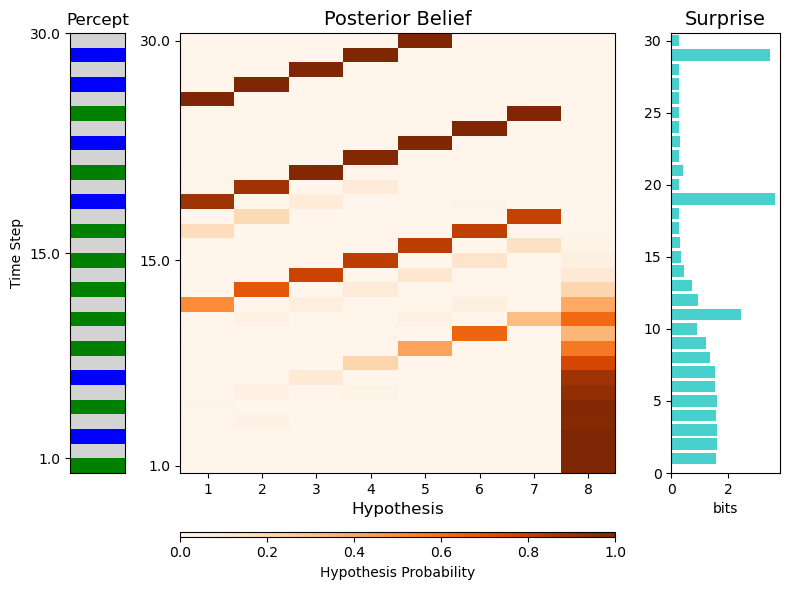

In [ ]:
from projective_simulation.methods.visualization import memory_filter_performance

memory_filter_performance(memory_data=test_stm.data_dic, 
                          observed_percepts=observed_percepts, 
                          colormap=colormap)

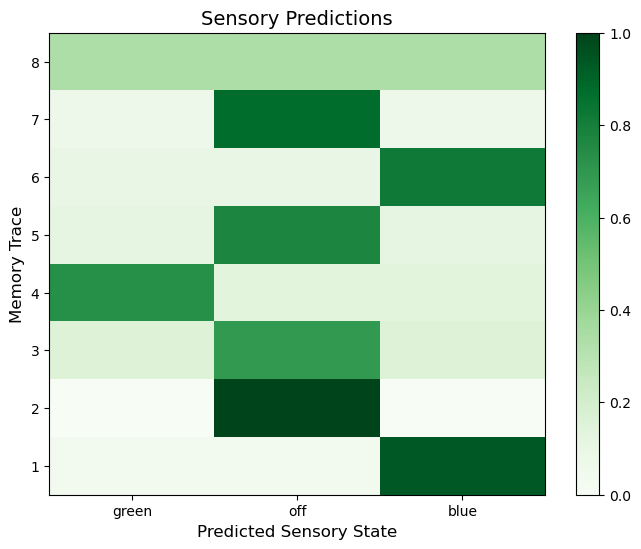

In [ ]:
plot_heatmap(test_stm.sensory_predictions, 
             title = "Sensory Predictions",
             xlabel = "Predicted Sensory State",
             xtick_labels = ["green", "off", "blue"],
             ylabel = "Memory Trace",
             color = "Greens",
             vmin = 0,
             vmax = 1
            )

### Long-Term Memory Filter

When the environment does not tend to repeat percepts in a cycle of fixed length, or sequences are long, short-term memory often fails. Here, we define changes to the memory that introduce Long-Term Memory. The long term memory filter encodes the surprise of each sensory state into a memory trace - higher surprise slows fading and thus increases the probability of reactivation upon a similar state. Reactivation also causes the sensory predictions of the memory to mix with current sensory activations - typically reinforcing the memory and counter-acting fading. Together, these dynamics stablize early memories of sequences. 

### Constructor Functions

In [ ]:
#| export
## Fading Rate Encoders
def sigmoid_fading_rate(gamma, sigma, sensor_state_probabilities, log_base = 2):
    #print(f'probabilites: {sensor_state_probabilities}')
    skew = np.log(gamma/(1-gamma))/np.log(log_base) #sets rate to gamma when logistic component is 0 (i.e. at sigmoid center)
    #print(f'skew: {skew}')
    shift = 2*sensor_state_probabilities - 1 #centers sigmoid at p = 0.5
    #print(f'shift: {shift}')
    scale = -np.log(1-sigma)/np.log(log_base) #slope of sigmoid
    #print(f'scale: {scale}')
    x = skew + scale * shift
    fading_rates = 1/(1 + log_base ** -x)
    #print(f'fading_rates: {fading_rates}')
    return(fading_rates)

def surprise_advantage_fading_rate(gamma,sigma, category_indexes, categorical_predictions, categorical_suprises, log_base = 2):
    sensor_labels, inv = np.unique(category_indexes, return_inverse=True)
    plogp = categorical_predictions * np.log(categorical_predictions)
    prediction_entropies = -np.bincount(inv, weights = plogp, minlength = sensor_labels.size) #sums the plogp for each value in category_indexer and returns as 1d array
    converted_entropies = prediction_entropies/np.log(log_base)
    surprise_gaps = categorical_surprises - converted_entropies
    fading_rates = gamma ** (log_base ** (sigma * surprise_gaps))
    return(fading_rates)

### Class Definition

In [ ]:
#| export
class Long_Term_Memory(Short_Term_Memory):
    """
    Long-Term Memory filter that extends Short_Term_Memory by introducing surprise-modulated memory fading and memory stabilization.
    Each encoded memory trace fades toward a uniform distribution at a rate modulated by the surprise of the encoded percept and by reactivation.
    Reactivation slows fading and can reinforce the memory trace, stabilizing early memories of sequences.

    Args:
        category_sizes (list): Number of sensory input elements.
        memory_capacity (int): Number of memory nodes.
        memory_bias (float): Transition probability from non-memory to memory hypothesis.
        fading_rate (float): Base rate parameter for exponential decay toward uniform for memory traces.
        surprise_factor (float, optional): Scales the degree to which surprise slows down memory fading.
        reuse_factor (float, optional): Scales the degree to which reactivation slows fading.
        sensory_predictions (np.ndarray, optional): Optional sensory-to-memory weight matrix.
        belief_prior (np.ndarray, optional): Optional 1d array of prior expectations on memories.
        transition_predictions (np.ndarray, optional): Optional memory transition matrix.
        timer (int, optional): Starting memory time index.
        data_record (list, optional): List of variable names to record each time step. Accepts "all".
        record_until (int, optional): Number of steps to prepare for data recording. Negative disables recording.
        fading_rate_method (str, optional): Method for computing fading rates ("sigmoid" or "surprise_advantage").
        capacity_overflow_method (str, optional): 'loop' or 'stop encoding'.
        schematic_transition_method (str, optional): 'encoded', 'first', or 'learned'.
    """
    def __init__(
        self,
        category_sizes: list,
        memory_capacity: int,
        memory_bias: float,
        fading_rate: float,
        surprise_factor: float = 0.,
        reuse_factor: float = 0.,
        sensory_predictions: np.ndarray = None,
        belief_prior: np.ndarray = None,
        transition_predictions: np.ndarray = None,
        timer: int = 0,
        data_record: list = [],
        record_until: int = -1,
        fading_rate_method = "sigmoid",
        capacity_overflow_method = "stop encoding",
        schematic_transition_method = "encoded"
    ):
        """
        Initialize the Long_Term_Memory filter.
        """
        super().__init__(
            category_sizes=category_sizes,
            memory_capacity=memory_capacity,
            memory_bias=memory_bias,
            fading_rate=fading_rate,
            sensory_predictions=sensory_predictions,
            belief_prior=belief_prior,
            transition_predictions=transition_predictions,
            timer=timer,
            data_record=data_record,
            record_until=record_until,
            capacity_overflow_method=capacity_overflow_method,
            schematic_transition_method=schematic_transition_method
        )
        assert 0 <= surprise_factor <= 1, "surprise_factor must be in [0, 1]"
        self.surprise_factor = surprise_factor
        self.reuse_factor = reuse_factor
        self.fading_rate_method = fading_rate_method
        self.memory_fade = np.zeros((np.shape(self.sensory_predictions)[0], len(self.category_sizes)))  # fading rates for all memories

    def learn(self, percept):
        """
        Given a percept, update world model and stabilize memories.
        """
        super().learn(percept)
        self.stablize_memories()

    def fade(self):
        """
        Apply exponential decay toward uniform distribution for each memory trace, using memory-specific fading rates.
        """
        for i in range(len(self.category_sizes)):
            faded_memories = _decay_toward_uniform(
                self.sensory_predictions[:, self.category_indexer == i],
                self.memory_fade[:, i]
            )
            self.sensory_predictions[:, self.category_indexer == i] = faded_memories

    def stablize_memories(self):
        """
        Reduce fading rate of reactivated memories according to the weight of reactivation (posterior belief).
        """
        for i in range(self.effective_capacity):
            self.memory_fade[i, :] = self.memory_fade[i, :] * (1 - (self.belief_posterior[i] * self.reuse_factor))

    def encode_memory(self, percept=None):
        """
        Encode the current percept into memory, updating sensory and transition predictions.
        Sets the initial fading rates of each category in the new memory.
        """
        super().encode_memory(percept)
        if not self.effective_capacity == self.memory_capacity or not self.capacity_overflow_method == "stop encoding":
            self.memory_fade[self.timer, :] = self.get_fading_rates()

    def capacity_reached(self):
        """
        Handle encoding of last memory hypothesis when memory capacity is reached.
        """
        super().capacity_reached()
        self.memory_fade[self.timer, :] = self.get_fading_rates()

    def get_fading_rates(self):
        """
        Compute the fading rates for the current memory trace using the selected fading_rate_method.
        """
        if self.fading_rate_method == "sigmoid":
            fading_rates = sigmoid_fading_rate(
                gamma=self.fading_rate,
                sigma=self.surprise_factor,
                sensor_state_probabilities=self.sensory_expectation[self.get_one_hot_percept()],
                log_base=self.log_base
            )
        elif self.fading_rate_method == "surprise_advantage":
            fading_rates = surprise_advantage_fading_rate(
                gamma=self.fading_rate,
                sigma=self.surprise_factor,
                category_indexes=self.category_indexer,
                categorical_predictions=self.sensory_expectation,
                categorical_suprises=self.get_surprise(),
                log_base=self.log_base
            )
        else:
            raise ValueError(f'{self.fading_rate_method} is not a valid fading_rate_method')
        return fading_rates


#### Example Long Term Memory

Here, we build an environment that alternates between sequences of different lengths ans show how the Long Term Memory Filter retains memories of its first encounters with new sequences. 

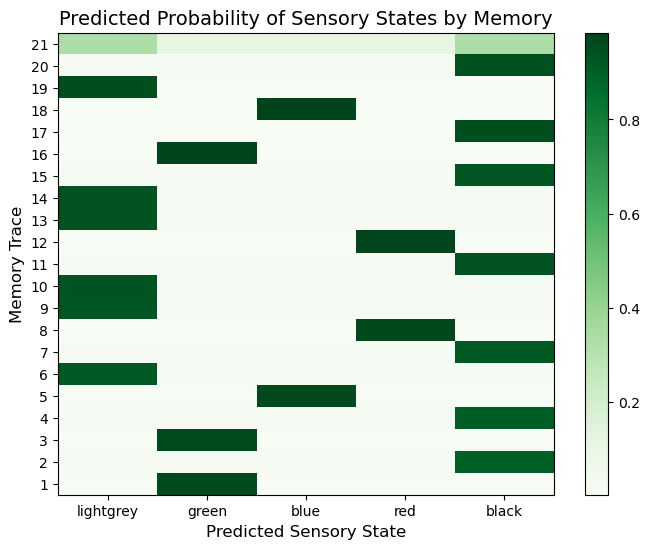

In [ ]:
from projective_simulation.environments import POMDP

#define percepts
off = 0
green = 1
blue = 2
red = 3
black = 4
colormap = np.array(['lightgrey', 'green', 'blue', 'red', 'black']) #for plotting

#define environment
percepts = np.array([0,1,2,3,4])
#set up environment
observation_function = np.array([(0.,1.,0.,0.,0.),
                                 (0.,0.,0.,0.,1.),
                                 (0.,0.,1.,0.,0.),
                                 (1.,0.,0.,0.,0.),
                                 (0.,0.,0.,0.,1.),
                                 (0.,0.,0.,1.,0.),
                                 (1.,0.,0.,0.,0.),
                                 (1.,0.,0.,0.,0.),
                                 (0.,0.,0.,0.,1.),
                                ])
transition_function = np.array([(0.,1.,0.,0.,0.,0.,0.,0.,0.),
                                (1/3,0.,1/3,0.,0.,1/3,0.,0.,0.),
                                (0.,0.,0.,1.,0.,0.,0.,0.,0.),
                                (0.,0.,0.,0.,1.,0.,0.,0.,0.),
                                (1/3,0.,1/3,0.,0.,1/3,0.,0.,0.),
                                (0.,0.,0.,0.,0.,0.,1.,0.,0.),
                                (0.,0.,0.,0.,0.,0.,0.,1.,0.),
                                (0.,0.,0.,0.,0.,0.,0.,0.,1.),
                                (1/3,0.,1/3,0.,0.,1/3,0.,0.,0.)
                               ])

alternating_cycles = POMDP(percepts = percepts, 
                           observation_function = observation_function, 
                           transition_function = transition_function[:,:,np.newaxis])

#set up memory filter
category_sizes = [5]
memory_capacity = 20
memory_bias = 0.001
fading_rate = 0.01
reuse_factor = 0.1
surprise_factor = 0.9

#give schematic hypothesis and unencoded memories default sensory predictions equal to stationary expectation
sensory_predictions = np.tile([3/9,1/9,1/9,1/9, 3/9], (memory_capacity + 1, 1))

test_ltm = Long_Term_Memory(category_sizes = category_sizes,
                            memory_capacity = memory_capacity,
                            memory_bias = memory_bias,
                            sensory_predictions = sensory_predictions,
                            fading_rate = fading_rate,
                            reuse_factor = reuse_factor, 
                            surprise_factor = surprise_factor
                           )

#prepare simulation
T = 30 #total time to run simulation
observed_percepts = ["None"] * T #data structure for storing observations
test_ltm.prepare_data_storage(data_record = ["all"], record_until = T)

#simulate
for t in range(T):
    percept = alternating_cycles.get_observation()
    observed_percepts[t] = percept
    test_ltm.sample(percept)
    alternating_cycles.transition(0) #use action 0 for environments with no action mediation

#Plot sensory predictions. Note that the oldest memories tend to be "sharper" then middle-age memories.
plot_heatmap(test_ltm.sensory_predictions, 
             title = "Predicted Probability of Sensory States by Memory",
             xlabel = "Predicted Sensory State",
             xtick_labels = ['lightgrey', 'green', 'blue', 'red', 'black'],
             ylabel = "Memory Trace",
             color = "Greens"
            )

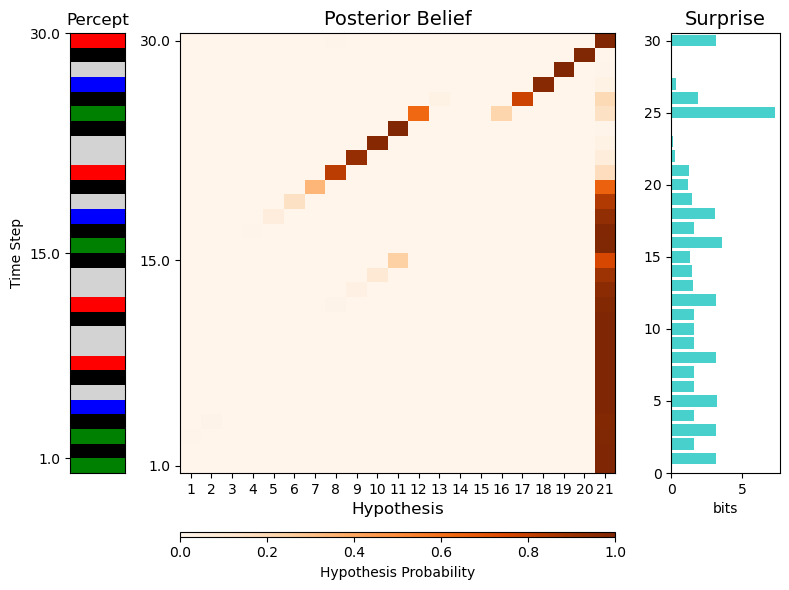

In [ ]:
from projective_simulation.methods.visualization import memory_filter_performance

memory_filter_performance(memory_data=test_ltm.data_dic, 
                          observed_percepts=observed_percepts, 
                          colormap=colormap)

### Associative Memory

In [ ]:
class Associative_Memory(Long_Term_Memory):
    """
    Associative Memory filter that extends Long_Term_Memory by introducing learning and re-encoding mechanisms.
    This class allows memory traces to be updated based on prediction differences (learning_factor) and reactivation (reencoding_factor).
    Transition weights between memory traces can be learned, and reactivation can reinforce or generalize memory traces.

    Args:
        category_sizes (list): Number of sensory input elements.
        memory_capacity (int): Number of memory nodes.
        memory_bias (float): Transition probability from non-memory to memory hypothesis.
        fading_rate (float): Base rate parameter for exponential decay toward uniform for memory traces.
        surprise_factor (float, optional): Scales the degree to which surprise slows down memory fading.
        reuse_factor (float, optional): Scales the degree to which reactivation slows fading.
        learning_factor (float, optional): Scales influence of prediction differences on transition weights.
        reencoding_factor (float, optional): Scales the degree to which re-activation of a memory affects its sensory predictions.
        sensory_predictions (np.ndarray, optional): Optional sensory-to-memory weight matrix.
        belief_prior (np.ndarray, optional): Optional 1d array of prior expectations on memories.
        transition_predictions (np.ndarray, optional): Optional memory transition matrix.
        timer (int, optional): Starting memory time index.
        data_record (list, optional): List of variable names to record each time step. Accepts "all".
        record_until (int, optional): Number of steps to prepare for data recording. Negative disables recording.
        fading_rate_method (str, optional): Method for computing fading rates ("sigmoid" or "surprise_advantage").
        capacity_overflow_method (str, optional): 'loop' or 'stop encoding'.
        schematic_transition_method (str, optional): 'encoded', 'first', or 'learned'.
    """
    def __init__(
        self,
        category_sizes: list,
        memory_capacity: int,
        memory_bias: float,
        fading_rate: float,
        surprise_factor: float = 0.,
        reuse_factor: float = 0.,
        learning_factor: float = 0.,
        reencoding_factor: float = 0.,
        sensory_predictions: np.ndarray = None,
        belief_prior: np.ndarray = None,
        transition_predictions: np.ndarray = None,
        timer: int = 0,
        data_record: list = [],
        record_until: int = -1,
        fading_rate_method = "sigmoid",
        capacity_overflow_method = "stop encoding",
        schematic_transition_method = "learned"
    ):
        """
        Initialize the Associative_Memory filter.
        """
        if schematic_transition_method == "learned" and transition_predictions is None:
            transition_predictions = Initialize_Memory_Based_Transition_Matrix(
                memory_capacity=memory_capacity,
                memory_bias=memory_bias,
                num_hypotheses=memory_capacity + 1,
                capacity_overflow_method=capacity_overflow_method,
                schematic_transition_method=schematic_transition_method,
            )

        super().__init__(
            category_sizes=category_sizes,
            memory_capacity=memory_capacity,
            memory_bias=memory_bias,
            fading_rate=fading_rate,
            surprise_factor=surprise_factor,
            sensory_predictions=sensory_predictions,
            reuse_factor=reuse_factor,
            belief_prior=belief_prior,
            transition_predictions=transition_predictions,
            timer=timer,
            data_record=data_record,
            record_until=record_until,
            fading_rate_method=fading_rate_method,
            capacity_overflow_method=capacity_overflow_method,
            schematic_transition_method=schematic_transition_method
        )
        self.learning_factor = learning_factor
        self.reencoding_factor = reencoding_factor
        self.presynaptic_activations = np.zeros_like(self.transition_predictions)  # initialize

    def sample(self, percept):
        """
        Given a percept; update belief state, update world model, predict next sensor states.
        Store last posterior and presynaptic activations for learning step.

        Args:
            percept (np.ndarray): The observed percept.

        Returns:
            np.ndarray: The predicted sensory expectation for the next step.
        """
        #retain last posterior and presynaptic activations for learning step
        self.last_posterior = self.belief_posterior.copy()
        self.presynaptic_activations = self.last_posterior[:, np.newaxis] * self.transition_predictions
        sensory_expectation = super().sample(percept)
        return sensory_expectation

    def learn(self, percept):
        """
        Given a percept, update world model per LTM, plus re-encode memories and update transitions.
        """
        super().learn(percept)
        self.reencode_memories()
        self.update_transitions()      

    def reencode_memories(self):
        """
        Re-encode memory traces by mixing old encoding with new encoding according to reactivation strength.
        """
        categorical_encoding = self.get_one_hot_percept().astype(float)
        for i in range(self.timer):
            reencoding_strength = self.reencoding_factor * self.belief_posterior[i]
            reencoded_memory = reencoding_strength * categorical_encoding + (1 - reencoding_strength) * self.sensory_predictions[i, :]
            self.sensory_predictions[i, :] = reencoded_memory

    def update_transitions(self):
        """
        Update transition weights between memory traces based on prediction differences and learning factor.
        """
        weighted_synapse_differences = self.learning_factor * (np.outer(self.last_posterior, self.belief_posterior) - self.presynaptic_activations)
        if self.schematic_transition_method == "learned":
            self.transition_predictions = self.transition_predictions + weighted_synapse_differences
        else:
            print("Warning: Transition updates ignored because schematic_transition_method is not 'learned'.")

#### Example Associative Memory

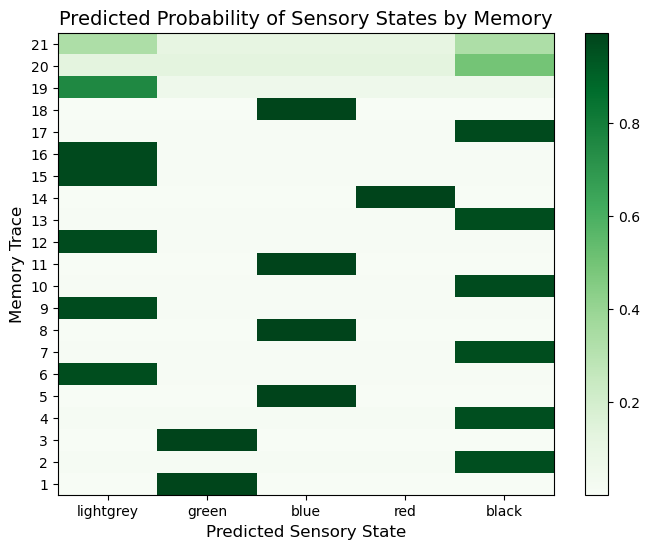

In [ ]:
from projective_simulation.environments import POMDP

#define percepts
off = 0
green = 1
blue = 2
red = 3
black = 4

#define environment
percepts = np.array([0,1,2,3,4])
#set up environment
observation_function = np.array([(0.,1.,0.,0.,0.),
                                 (0.,0.,0.,0.,1.),
                                 (0.,0.,1.,0.,0.),
                                 (1.,0.,0.,0.,0.),
                                 (0.,0.,0.,0.,1.),
                                 (0.,0.,0.,1.,0.),
                                 (1.,0.,0.,0.,0.),
                                 (1.,0.,0.,0.,0.),
                                 (0.,0.,0.,0.,1.),
                                ])
transition_function = np.array([(0.,1.,0.,0.,0.,0.,0.,0.,0.),
                                (1/3,0.,1/3,0.,0.,1/3,0.,0.,0.),
                                (0.,0.,0.,1.,0.,0.,0.,0.,0.),
                                (0.,0.,0.,0.,1.,0.,0.,0.,0.),
                                (1/3,0.,1/3,0.,0.,1/3,0.,0.,0.),
                                (0.,0.,0.,0.,0.,0.,1.,0.,0.),
                                (0.,0.,0.,0.,0.,0.,0.,1.,0.),
                                (0.,0.,0.,0.,0.,0.,0.,0.,1.),
                                (1/3,0.,1/3,0.,0.,1/3,0.,0.,0.)
                               ])

alternating_cycles = POMDP(percepts = percepts, 
                           observation_function = observation_function, 
                           transition_function = transition_function[:,:,np.newaxis])

#set up memory filter
category_sizes = [5]
memory_capacity = 20
memory_bias = 0.00005
fading_rate = 0.003
reuse_factor = 0.1
surprise_factor = 0.96
reencoding_factor = 0.05
learning_factor = 0.2

#give schematic hypothesis and unencoded memories default sensory predictions equal to stationary expectation
sensory_predictions = np.tile([3/9,1/9,1/9,1/9, 3/9], (memory_capacity + 1, 1))

test_am = Associative_Memory(category_sizes = category_sizes,
                          memory_capacity = memory_capacity,
                          memory_bias = memory_bias,
                          sensory_predictions = sensory_predictions,
                          fading_rate = fading_rate,
                          reuse_factor = reuse_factor,
                          reencoding_factor = reencoding_factor,
                          surprise_factor = surprise_factor,
                          learning_factor = learning_factor
                         )

#prepare simulation
T = 50 #total time to run simulation
observed_percepts = ["None"] * T #data structure for storing observations
test_am.prepare_data_storage(data_record = ["all"], record_until = T)

#simulate
for t in range(T):
    percept = alternating_cycles.get_observation()
    observed_percepts[t] = percept
    test_am.sample(percept)
    alternating_cycles.transition(0) #use action 0 for environments with no action mediation

#Plot sensory predictions. Note that the oldest memories tend to be "sharper" then middle-age memories.
plot_heatmap(test_am.sensory_predictions, 
             title = "Predicted Probability of Sensory States by Memory",
             xlabel = "Predicted Sensory State",
             xtick_labels = ['lightgrey', 'green', 'blue', 'red', 'black'],
             ylabel = "Memory Trace",
             color = "Greens"
            )

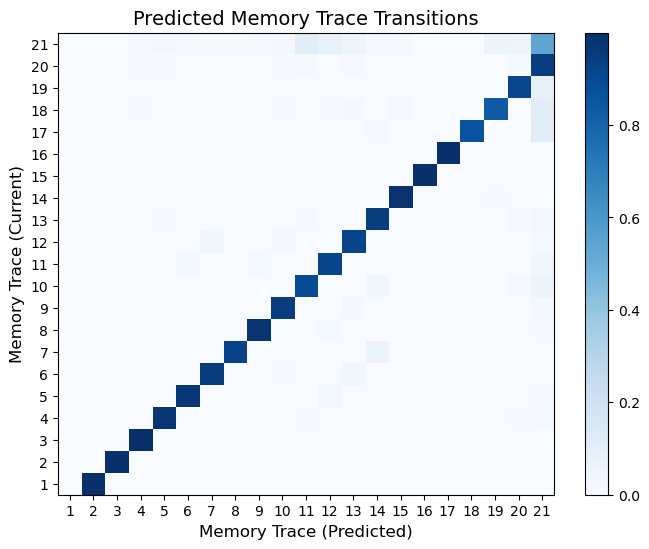

In [ ]:
#Plot transition predictions
plot_heatmap(test_am.transition_predictions[:50,:50], 
             title = "Predicted Memory Trace Transitions",
             xlabel = "Memory Trace (Predicted)", 
             ylabel = "Memory Trace (Current)",                   
            )

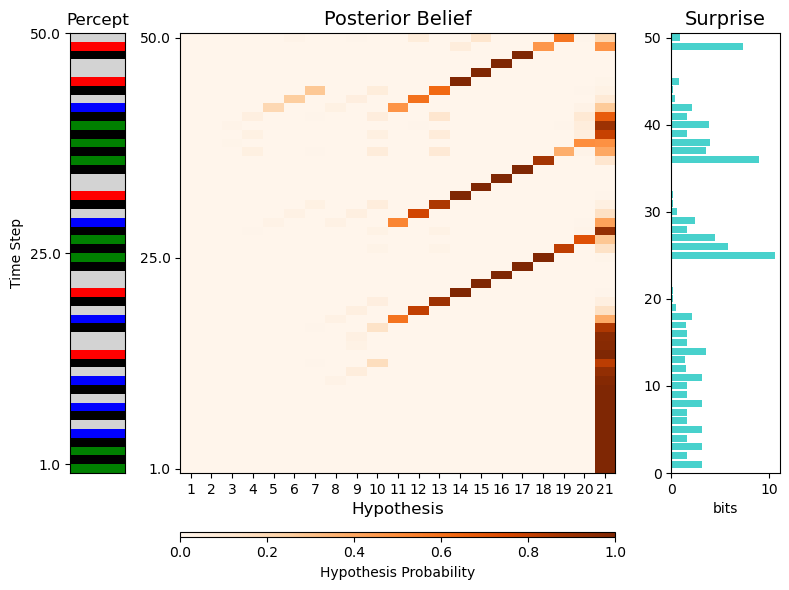

In [ ]:
from projective_simulation.methods.visualization import memory_filter_performance

memory_filter_performance(memory_data=test_am.data_dic, 
                          observed_percepts=observed_percepts, 
                          colormap=colormap)

## Hierarchical Bayes

In [ ]:
import numpy as np
from itertools import product
from typing import Sequence, Optional, List, Tuple

class Hierarchical_Bayes_Filter(Abstract_ECM):
    """
    Hierarchical Bayes filter that instantiates the Eq. (6) construction:
      • For every supported environment size n with p(N=n) > 0 and every sequence s^(1:n) ∈ S^n,
        create a disjoint hypothetical HMM with n latent states in a deterministic cycle and
        deterministic observations p(s_k | x_k) = 1.
      • The global latent space is the disjoint union of all such HMMs.
      • The initial belief mixes partitions by their prior p(N=n) times the i.i.d. sensory-bias
        sequence probability; within each partition all mass is on its first state.

    Internally:
      • next_state : (N_latent,) int — deterministic transition mapping for each latent state
      • emit_symbol: (N_latent,) int — which sensory symbol is emitted deterministically
      • belief_state: (N_latent,) float — predictive belief p(x_t | s_{1:t-1})
    """

    def __init__(self,
                 sensory_size: int,                                  # |S|: number of sensory categories
                 sensory_bias: Sequence[float],                      # length-|S| pmf over sensory symbols (implicit bias), sums to 1
                 env_sizes: Sequence[int],                           # supported environment sizes (e.g., [1,2,3])
                 env_size_probs: Sequence[float],                    # pmf over env_sizes, same length, sums to 1
                 dtype: type = np.float64                            # numeric dtype
                 ):
        super().__init__()

        # ---------------------- Validate + coerce inputs ----------------------
        self.S: int = int(sensory_size)
        self.pi_s: np.ndarray = np.asarray(sensory_bias, dtype=dtype).reshape(-1)
        assert self.pi_s.shape == (self.S,), "sensory_bias must have length == sensory_size"
        self.pi_s = self._normalize(self.pi_s)

        self.env_sizes: np.ndarray = np.asarray(env_sizes, dtype=int).reshape(-1)
        self.p_env: np.ndarray = np.asarray(env_size_probs, dtype=dtype).reshape(-1)
        assert self.env_sizes.ndim == 1 and self.p_env.ndim == 1, "env_sizes/env_size_probs must be 1D"
        assert self.env_sizes.size == self.p_env.size, "env_sizes and env_size_probs must match in length"
        assert np.all(self.env_sizes >= 1), "Environment sizes must be >= 1"
        self.p_env = self._normalize(self.p_env)
        self.dtype = dtype

        # ---------------------- Plan sizes; guard against blow-up ----------------------
        # Number of partitions for a given n is S**n; total latent states sum_n n * S**n.
        try:
            part_counts = [self.S ** int(n) for n in self.env_sizes.tolist()]
        except OverflowError:
            raise ValueError("S ** n overflowed. Reduce S or n.")
        total_partitions = int(sum(part_counts))
        total_states = int(sum(int(n) * (self.S ** int(n)) for n in self.env_sizes.tolist()))

        # Light sanity cap to avoid accidental combinatorial explosions.
        # Adjust or remove if you know your sizes are manageable.
        MAX_LATENT = 250_000
        if total_states > MAX_LATENT:
            raise ValueError(
                f"Requested construction yields {total_states} latent states, which exceeds the "
                f"safe cap ({MAX_LATENT}). Reduce env_sizes and/or S, or add a custom generator."
            )

        # ---------------------- Allocate global structures ----------------------
        self.N_latent: int = total_states
        self.next_state: np.ndarray = np.empty(self.N_latent, dtype=np.int64)  # src -> dst
        self.emit_symbol: np.ndarray = np.empty(self.N_latent, dtype=np.int64) # deterministic emission
        self.belief_state: np.ndarray = np.zeros(self.N_latent, dtype=dtype)   # predictive prior

        # For reset: remember each partition's first-state index and its (unnormalized) weight
        first_state_indices: List[int] = []
        partition_weights_unnorm: List[float] = []

        # Optional: metadata slices (start, stop) per partition; can be handy for inspection
        self.partition_slices: List[Tuple[int, int]] = []

        # ---------------------- Build partitions per Eq. (6) ----------------------
        cursor = 0  # running index into the concatenated latent state vector
        for n_idx, n in enumerate(self.env_sizes.tolist()):
            pn = float(self.p_env[n_idx])  # p(N=n)
            # Enumerate all sequences s^(1:n) ∈ S^n
            for seq in product(range(self.S), repeat=int(n)):
                start = cursor
                stop = start + int(n)
                # Deterministic observation: state k emits seq[k]
                for k in range(int(n)):
                    idx = start + k
                    self.emit_symbol[idx] = int(seq[k])
                    # Deterministic cycle transition
                    self.next_state[idx] = start + ((k + 1) % int(n))
                # Prior weight for this partition: p(N=n) * prod_k pi_s[seq[k]]
                seq_prob = 1.0
                for sym in seq:
                    seq_prob *= float(self.pi_s[int(sym)])
                w = pn * seq_prob

                # Initial prior: conditional on partition -> all mass on first state
                first_state_indices.append(start)
                partition_weights_unnorm.append(w)

                # Record slice and advance
                self.partition_slices.append((start, stop))
                cursor = stop

        assert cursor == self.N_latent, "Internal size accounting error."

        # ---------------------- Initialize belief (mixture over partitions) ----------------------
        Z = float(np.sum(partition_weights_unnorm))
        if Z == 0.0 or not np.isfinite(Z):
            # Degenerate case (e.g., sensory_bias had zeros everywhere): fall back to uniform over partitions
            norm_weights = np.ones(len(partition_weights_unnorm), dtype=self.dtype) / max(1, len(partition_weights_unnorm))
        else:
            norm_weights = np.asarray(partition_weights_unnorm, dtype=self.dtype) / Z

        for idx, w in zip(first_state_indices, norm_weights.tolist()):
            self.belief_state[idx] += w

        # Keep for resets
        self._first_state_indices = np.asarray(first_state_indices, dtype=np.int64)
        self._partition_weights_norm = np.asarray(norm_weights, dtype=self.dtype)

        # Bookkeeping for last update
        self._last_posterior: Optional[np.ndarray] = None
        self._last_observation: Optional[int] = None

    # -------------------------------------------------------------------------
    # Core update: deterministic likelihood + deterministic transition
    # -------------------------------------------------------------------------
    def sample(self,
               sensory_state: int  # observed sensory symbol index at time t, in [0, S-1]
               ) -> np.ndarray:
        """
        Consume an observation s_t, perform Bayes update, predict one step ahead, and
        return the *prior over sensory* at t+1, i.e. p(s_{t+1} | s_{1:t}).

        Returns
        -------
        p_next_sensory : (S,) ndarray
            Distribution over sensory symbols for the next time step.
        """
        s = int(sensory_state)
        if not (0 <= s < self.S):
            raise ValueError(f"sensory_state must be in [0, {self.S-1}]")

        # Likelihood is 1 for states whose deterministic emission == s, else 0
        mask = (self.emit_symbol == s)
        posterior_unnorm = self.belief_state * mask.astype(self.belief_state.dtype)
        total = posterior_unnorm.sum()

        if not np.isfinite(total) or total <= 0:
            # Incompatible evidence under current predictive belief: reset support to all states emitting s
            # and renormalize uniformly on that support (conservative, avoids NaNs).
            support = np.where(mask)[0]
            if support.size == 0:
                # Should never happen given construction, but guard anyway
                posterior = np.ones_like(self.belief_state) / self.N_latent
            else:
                posterior = np.zeros_like(self.belief_state)
                posterior[support] = 1.0 / support.size
        else:
            posterior = posterior_unnorm / total

        # Deterministic time prediction: shove probability mass along next_state permutation
        predictive_next = np.zeros_like(self.belief_state)
        predictive_next[self.next_state] = posterior  # permutation write

        # Prior over s_{t+1}: sum predictive mass by emitted symbol
        p_next_sensory = np.bincount(self.emit_symbol, weights=predictive_next, minlength=self.S).astype(self.dtype)
        p_next_sensory = self._normalize(p_next_sensory)

        # Advance internal predictive belief and cache posterior
        self._last_posterior = posterior
        self._last_observation = s
        self.belief_state = predictive_next

        return p_next_sensory

    # -------------------------------------------------------------------------
    # Convenience / inspection
    # -------------------------------------------------------------------------
    def reset_belief(self):
        """Reset to the construction-time hierarchical prior (all mass on each partition's first state, mixed by its prior)."""
        self.belief_state.fill(0.0)
        for idx, w in zip(self._first_state_indices.tolist(), self._partition_weights_norm.tolist()):
            self.belief_state[int(idx)] += float(w)
        self._last_posterior = None
        self._last_observation = None

    def current_posterior(self) -> Optional[np.ndarray]:
        """Return p(x_t | s_{1:t}) from the most recent update (None if sample() not yet called)."""
        return None if self._last_posterior is None else self._last_posterior.copy()

    def dense_T(self) -> np.ndarray:
        """Materialize the deterministic transition matrix T (N×N), where T[i, j]=1 iff j = next_state[i]."""
        T = np.zeros((self.N_latent, self.N_latent), dtype=self.dtype)
        T[np.arange(self.N_latent, dtype=np.int64), self.next_state] = 1.0
        return T

    def dense_O(self) -> np.ndarray:
        """Materialize the deterministic observation matrix O (N×S), where O[i, s]=1 iff s == emit_symbol[i]."""
        O = np.zeros((self.N_latent, self.S), dtype=self.dtype)
        O[np.arange(self.N_latent, dtype=np.int64), self.emit_symbol] = 1.0
        return O

    # -------------------------------------------------------------------------
    # Utilities
    # -------------------------------------------------------------------------
    @staticmethod
    def _normalize(x: np.ndarray) -> np.ndarray:
        s = float(np.sum(x))
        if not np.isfinite(s) or s <= 0:
            return np.ones_like(x) / max(1, x.size)
        return x / s

In [ ]:
# Tiny example: S=3, env sizes {2,3}
S = 3
pi = [0.6, 0.3, 0.1]
env_sizes = [2, 3]
p_env = [0.7, 0.3]
h = Hierarchical_Bayes_Filter(S, pi, env_sizes, p_env)

# Observe symbol 0 twice
print("N_latent =", h.N_latent)
p_next = h.sample(0)
print("p(s_{t+1}|obs=[0]) =", np.round(p_next, 4))
p_next = h.sample(0)
print("p(s_{t+1}|obs=[0,0]) =", np.round(p_next, 4))

N_latent = 99
p(s_{t+1}|obs=[0]) = [0.6 0.3 0.1]
p(s_{t+1}|obs=[0,0]) = [0.88 0.09 0.03]


#| hide
# nbdev export

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()